## Predicting severe crashes from DC Crash Data

In the following exercise I attempt to predict whether an accident will involve serious injuries or fatalities, using DC Crash Data.  I use two methods: Random Forest classifiers, and Logistic Regression classifiers.  I compare the scores and interpret the results.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

%matplotlib inline

In [70]:
df = pd.read_csv('data/cleaned_crashes.csv', low_memory=False)

### Final preparation of data for modeling
Dropping unneeded columns, and dropping rows with missing or invalid data.

In [71]:
df.drop(columns=['reportdate','streetsegid','routeid','roadwaysegid','address','ward'], inplace=True)

In [72]:
df.replace([np.inf, -np.inf], np.nan)
df.isnull().sum()
df.dropna(inplace=True)

df.date_r = df.date_r.astype('datetime64[ns]')
df.to_csv('data/random_forest_data.csv')

### Random Forest

1. clean up data (for nulls, etc.)
2. split the data (train/test)
3. create model instance
4. fit the data
5. predict and score

In [73]:
df.columns

Index(['x', 'y', 'majorinjuries_bicyclist', 'minorinjuries_bicyclist',
       'fatal_bicyclist', 'majorinjuries_driver', 'minorinjuries_driver',
       'fatal_driver', 'majorinjuries_pedestrian', 'minorinjuries_pedestrian',
       'fatal_pedestrian', 'total_vehicles', 'total_bicycles',
       'total_pedestrians', 'pedestriansimpaired', 'bicyclistsimpaired',
       'driversimpaired', 'total_taxis', 'total_government',
       'speeding_involved', 'offintersection', 'intapproachdirection',
       'ward_number', 'date_r', 'fatal', 'injuries_any', 'day_of_week',
       'ped_inj_or_fatal', 'driver_inj_or_fatal', 'bike_inj_or_fatal'],
      dtype='object')

I am pulling in the features that are most likely to successfully predict major injuries and fatalities from the crash data.  I'm selecting either my engineered features or features that came with the original dataset, but taking care to not include non-independent features.

In this pass I try to predict if there are any injuries in a crash.

In [74]:
#'speeding_involved','total_pedestrians','total_bicycles',
# 'total_vehicles','ward_number' (or x and y), and possibly impairment
feature_cols = ['speeding_involved','total_pedestrians','total_bicycles',
               'total_vehicles','ward_number','x','y', 'bicyclistsimpaired',
               'driversimpaired','pedestriansimpaired','offintersection']

X = df[feature_cols]
y = df['injuries_any']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [76]:
print(X_train.shape, y_train.shape)
y_train.describe()
print(X_train.dtypes)

(106255, 11) (106255,)
speeding_involved      float64
total_pedestrians      float64
total_bicycles           int64
total_vehicles         float64
ward_number            float64
x                      float64
y                      float64
bicyclistsimpaired       int64
driversimpaired          int64
pedestriansimpaired      int64
offintersection        float64
dtype: object


The confusion matrix shows that my ability to identify the Major Injuries/Death status is okay, but my non-major crashes are less likely to be accurately predicted.  

In [77]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

pd.crosstab(y_test, predictions, rownames=['Actual Status'], colnames=['Predicted Status'])

Predicted Status,0,1
Actual Status,,
0,17950,1936
1,5133,1545


The most significant feature in the model is 'offintersection', which is the distance to the nearest intersection.  The coordinates of the crash are the only other somewhat significant indicators of outcomes, the rest of the features playing very minor roles.

In [78]:
list(zip(X_train, rfc.feature_importances_))


[('speeding_involved', 0.027338377488880353),
 ('total_pedestrians', 0.03240510149153801),
 ('total_bicycles', 0.01540012958475491),
 ('total_vehicles', 0.02839342515304969),
 ('ward_number', 0.01193359945514013),
 ('x', 0.275480909977454),
 ('y', 0.2835394422331898),
 ('bicyclistsimpaired', 8.071094916361249e-05),
 ('driversimpaired', 0.0026086121197870836),
 ('pedestriansimpaired', 0.00038846409254070956),
 ('offintersection', 0.3224312274545019)]

In [79]:
rfc.score(X_test, y_test)

0.7338879686794157

I ran through a large range of k to identify the best number of regressors.  It tapered off around 50 with only slight improvements through 99.

In [80]:
# What's the best number of regressors?
rsq_list = []

#for k in range(2, 100):  # super slow...
for k = 50:
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    score = rfc.score(X_test, y_test)
    rsq_list.append(score)

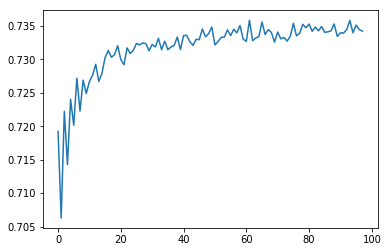

In [81]:
plt.plot(rsq_list)

In [82]:
list(zip(X_train, rfc.feature_importances_))

[('speeding_involved', 0.027277156689080432),
 ('total_pedestrians', 0.03276658733160726),
 ('total_bicycles', 0.015743127187417223),
 ('total_vehicles', 0.027666230375658407),
 ('ward_number', 0.012274605477893193),
 ('x', 0.27551179909800244),
 ('y', 0.2827456373646112),
 ('bicyclistsimpaired', 7.150212222556042e-05),
 ('driversimpaired', 0.0025219317130516085),
 ('pedestriansimpaired', 0.00034430457620306977),
 ('offintersection', 0.3230771180642495)]

In [83]:
max(rsq_list)

0.7358455051950008

### Random Forest to predict major injuries or fatalities (vs minor injuries and no injuries)
Here I try to predict the major injuries and fatalities among the crash data.  I'll update my dataframe to include a field for major_fatal, to use as labels. 

In [84]:
df.columns
df['major_fatal'] = 0
df.loc[((df.majorinjuries_bicyclist>0) | (df.fatal_bicyclist>0) | 
        (df.majorinjuries_driver>0) | (df.fatal_driver>0) | 
        (df.majorinjuries_pedestrian>0) | (df.fatal_pedestrian>0)), 'major_fatal'] = 1

df.major_fatal.sum()

12312

In [85]:
feature_cols = ['speeding_involved','total_pedestrians','total_bicycles',
               'total_vehicles','ward_number','x','y', 'bicyclistsimpaired',
               'driversimpaired','pedestriansimpaired','offintersection']

X = df[feature_cols]
y = df['major_fatal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [86]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
pd.crosstab(y_test, predictions)

col_0,0,1
major_fatal,,
0,23702,441
1,2338,83


My model score is fairly good.  But don't be fooled by that score--the confusion matrix above clearly demonstrates that my model grossly underpredicts the minority case.  Having a strong model score is meaningless if the minority data cannot be predicted.

In [87]:
score = rfc.score(X_test, y_test)
score

0.8953847312151785

In [88]:
list(zip(X_train, rfc.feature_importances_))

[('speeding_involved', 0.013005743723918802),
 ('total_pedestrians', 0.004303333732336504),
 ('total_bicycles', 0.002032447870522183),
 ('total_vehicles', 0.023635768245729324),
 ('ward_number', 0.013096704476009313),
 ('x', 0.2929717175871555),
 ('y', 0.2996872471776221),
 ('bicyclistsimpaired', 0.0002866732367279225),
 ('driversimpaired', 0.0015567288491673164),
 ('pedestriansimpaired', 0.0005152002922958394),
 ('offintersection', 0.34890843480851536)]

### Artificial Subsampling

We saw that the score above, predicting accidents with major injuries or fatalities, was very good at 0.895.  However, the associated confusion matrix indicates that our model predicted very few of the actual major injury/fatal accidents (86 of 2335), so it was actually not a good model.  Far fewer than the lower-scoring limited feature_columns dataset (score 0.734, but predicting 1543 of 5135 major/fatal accidents).  

I'll try to better train the model by upsampling the training set to balance the major/fatal incidences with the non-major/non-fatal accidents.  I'll select random samples from each category and use these as my training data.  I'll also reduce my testing data ratio to 10%, to allow more data on which to train.

References: https://elitedatascience.com/imbalanced-classes, 

In [89]:
df[df.major_fatal == 1].shape[0] / df[df.major_fatal == 0].shape[0]
#df.sample()
majors = df.loc[df.major_fatal == 1]
low_injuries = df.loc[df.major_fatal == 0]
low_injuries.shape

#majors.sample(11000)
#low_injuries.sample(20000)

(120507, 31)

Resize my minority class (major injuries or fatalities) to equal the size of my majority class.  I'll resample with replacement to achieve this, getting 120,507 samples.

In [90]:

df_majors_upsampled = resample(majors, replace=True, n_samples=120507, random_state=42)
df_upsampled = pd.concat([df_majors_upsampled, low_injuries])

## Random Forest with Upsampling and Clustering

##### Improving results with upsampled minority data (FIXED Upsampling - in progress)

Below I re-run the random forest classification model, using the upsampled data (in which major injury/fatal accidents occur as often as the non-injury/minor-injury accidents).  

Accuracy scoring is decreased slightly from 0.895 to 0.871, but the confusion matrix is tremendously improved, from 0.98% accuracy non-major and 4% accuracy major/fatal, to 74% accuracy non-major and 95% accuracy major/fatal accidents.


### K-Means Clustering 

Add a clustering field to my data.  Use it as another feature in Random Forest and Logistic Classification and KNN Classification.

In [153]:
# how to add clustering??  And include in features for logistic regression or random forest?
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [154]:
km.labels_
len(km.labels_)

132819

In [155]:
km2 = KMeans(n_clusters=3, random_state=42, n_jobs=-2)
km2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-2, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [156]:
km2.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [164]:
df['cluster'] = km2.labels_
feature_cols.append('cluster')

### Random Forest with Clustering and Upsampling

In [158]:
X = df[feature_cols]
y = df.major_fatal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# combine training sets to upsample
training_df = pd.concat([X_train, y_train], axis=1)

minority_data = training_df.loc[training_df.major_fatal > 0]
majority_data = training_df.loc[training_df.major_fatal == 0]

# upsample minority data, then join back with majority
minority_data = resample(minority_data, replace=True, n_samples=120507, random_state=42)
rf_upsampled = pd.concat([minority_data, majority_data])

X_train = rf_upsampled[feature_cols]
y_train = rf_upsampled.major_fatal

testing_df = pd.concat([X_test, y_test], axis=1)

rf_minority_id_rate = []  # since we're iterating over a larger set of k's, keep track...
rf_majority_id_rate = []

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)  # NEW: 312/(312+887) = 312/1199 = 0.2602
print(rfc.score(X_test, y_test) # without clustering: 0.755  WITH Clustering: 0.762)
pd.crosstab(y_test, predictions)  # OLD: 311/(946+311) = 311/1257 = 0.2474

col_0,0,1
major_fatal,,
0,9810,2273
1,887,312


In [198]:
%%time
# Looping over various clusters and 50 n_estimators
while 'cluster' in feature_cols:
    feature_cols.remove('cluster')
    #print('removing cluster from feature cols')
    
for k in range(2,14):
    while 'cluster' in feature_cols:
        feature_cols.remove('cluster')
    #print(feature_cols)    
    print('k = {}'.format(k))
    km = KMeans(n_clusters=k, random_state=42, n_jobs=-2)
    km.fit(X)
    df['cluster'] = km.labels_
    feature_cols.append('cluster')
    #print(feature_cols)
    
    X = df[feature_cols]
    y = df.major_fatal

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    #print('shape of X_train: ', str(X_train.shape))
    #print('shape of X_test: ', str(X_test.shape))    

    # combine training sets to upsample
    training_df = pd.concat([X_train, y_train], axis=1)

    minority_data = training_df.loc[training_df.major_fatal > 0]
    majority_data = training_df.loc[training_df.major_fatal == 0]
    #print('shape of minority data: ', str(minority_data.shape))

    # upsample minority data, then join back with majority
    minority_data = resample(minority_data, replace=True, n_samples=120507, random_state=42)
    rf_upsampled = pd.concat([minority_data, majority_data], axis=0)
    #print('rf_upsampled shape: ', str(rf_upsampled.shape))
    
    X_train = rf_upsampled[feature_cols]
    y_train = rf_upsampled.major_fatal
    #print('X_train shape after upsampling: ', str(X_train.shape))

    testing_df = pd.concat([X_test, y_test], axis=1)
    #print('testing df shape: ', str(testing_df.shape))

    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    #print('Predicting on X_test, shape ', str(X_test.shape))
    predictions = rfc.predict(X_test)  # NEW: 312/(312+887) = 312/1199 = 0.2602
    print('score: ')
    print(rfc.score(X_test, y_test)) # without clustering: 0.755  WITH Clustering: 0.762)
    crosstab = pd.crosstab(y_test, predictions)  # OLD: 311/(946+311) = 311/1257 = 0.2474
    print(crosstab)
    
    print()

k = 2
score: 
0.7613311248305978
col_0           0     1
major_fatal            
0            9796  2258
1             912   316

k = 3
score: 
0.749887065201024
col_0           0     1
major_fatal            
0            9662  2370
1             952   298

k = 4
score: 
0.7574913416654119
col_0           0     1
major_fatal            
0            9734  2307
1             914   327

k = 5
score: 
0.7531998193043217
col_0           0     1
major_fatal            
0            9705  2376
1             902   299

k = 6
score: 
0.7584701099232043
col_0           0     1
major_fatal            
0            9738  2320
1             888   336

k = 7
score: 
0.7554585152838428
col_0           0     1
major_fatal            
0            9746  2322
1             926   288

k = 8
score: 
0.7568890227375396
col_0           0     1
major_fatal            
0            9710  2335
1             894   343

k = 9
score: 
0.7495859057370878
col_0           0     1
major_fatal            
0         

### Logistic Regression (now with clusters) - much worse

I'll also attempt a classification using logistic regression.  I'll use the same up-sampled data from above and compare the scores.  As I feared, the score is quite weak, even with an upsampled minority class.  I do not recommend the Logistic Regression Model for this exercise.

Features:  feature_cols = ['speeding_involved','total_pedestrians','total_bicycles',
               'total_vehicles','ward_number','x','y', 'bicyclistsimpaired',
               'driversimpaired','pedestriansimpaired','offintersection']

In [175]:
print(feature_cols)

['speeding_involved', 'total_pedestrians', 'total_bicycles', 'total_vehicles', 'ward_number', 'x', 'y', 'bicyclistsimpaired', 'driversimpaired', 'pedestriansimpaired', 'offintersection']


In [176]:
print(X_train.columns)

Index(['speeding_involved', 'total_pedestrians', 'total_bicycles',
       'total_vehicles', 'ward_number', 'x', 'y', 'bicyclistsimpaired',
       'driversimpaired', 'pedestriansimpaired', 'offintersection', 'cluster'],
      dtype='object')


In [160]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test)


0.40377955127239873

In [167]:
# Without cluster:
if 'cluster' in feature_cols:
    print ('its in there')
    feature_cols.pop()

lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test)


0.40377955127239873

In [171]:
%%timeit
kfold = model_selection.KFold(n_splits=10, random_state=42)
model = LogisticRegression()
result = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
result.mean()

8.56 s ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [172]:
print(result)
result.mean()

[0.27771469 0.27244136 0.27567379 0.27929935 0.27340235 0.34442843
 0.0478749  0.05241777 0.05184991 0.04949111]


0.19245936437039673

In [173]:
pd.crosstab(y_test, predictions)  # 866/(866+333) = 866/1199 = 0.7223

col_0,0,1
major_fatal,,
0,4497,7586
1,333,866


In [174]:
X_test.shape

(13282, 12)

### Logistic Regression with Clusters AND Upsampling

In [177]:
if not 'cluster' in feature_cols:
    feature_cols.append('cluster')

X = df[feature_cols]
y = df.major_fatal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
training_df = pd.concat([X_train, y_train], axis=1)

minority_data = training_df.loc[training_df.major_fatal > 0]
majority_data = training_df.loc[training_df.major_fatal == 0]

minority_data = resample(minority_data, replace=True, n_samples=120507, random_state=42)
knn_upsampled = pd.concat([minority_data, majority_data])

X_train = knn_upsampled[feature_cols]
y_train = knn_upsampled.major_fatal

testing_df = pd.concat([X_test, y_test], axis=1)

lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test)

0.4169552778196055

In [178]:
kfold = model_selection.KFold(n_splits=10, random_state=42)
model = LogisticRegression()
result = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
print(result)
result.mean()

[0.28004193 0.27820731 0.27750841 0.27729    0.27956144 0.3506312
 0.05451448 0.05106364 0.05180623 0.05062904]


0.1951253685800931

In [179]:
pd.crosstab(y_test, predictions)  # 866/(866+333) = 866/1199 = 0.7223

col_0,0,1
major_fatal,,
0,4717,7368
1,376,821


### KNN Classification

Since it is plausible that serious accidents occur frequently in the most dangerous street segments and intersections, I'll attempt a KNN Classification model to determine if I can predict major injuries or fatalities.

Note, I'll use KNN without the upsampling used in other models.

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X = df[feature_cols]
y = df.major_fatal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
knn_scores = []
scoremax = 0
kmax = 0

for k in range(1,41):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    knn_scores.append((k, score))
    if score > scoremax:
        scoremax = score
        kmax = k

print('Best score of {} first identified at k={}'.format(scoremax, kmax))

Best score of 0.910179189881042 first identified at k=17


The best score I got was 0.91.  Superficially this model looks promising, but we must ensure that the minority values are accurately classified before we have confidence in the score.  

The following confusion matrix shows a sensitivity of less than 1%, so this is in fact a terrible predictive model of major injuries or fatalities.

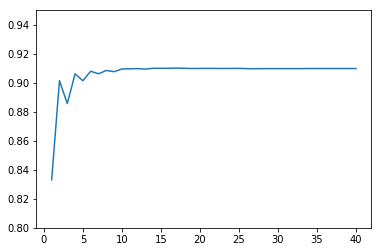

In [101]:
#plt.plot(x=knn_scores.keys, y=knn_scores[knn_scores.keys])
x_vals = [x[0] for x in knn_scores]
y_vals = [y[1] for y in knn_scores]

plt.ylim((0.8,0.95))
plt.plot(x_vals, y_vals, )
plt.show()

In [102]:
knn = KNeighborsClassifier(n_neighbors=kmax)
knn.fit(X_train, y_train)
df_knn = df.copy(deep=True)
df_knn['y_predictions'] = knn.predict(df_knn[feature_cols])

In [103]:
pd.crosstab(df_knn.major_fatal, df_knn.y_predictions)

y_predictions,0,1
major_fatal,,
0,120486,21
1,12284,28


### KNN Classification with Upsampling (FIXED Upsampling!)

With upsampled minority data, I still have a poor classifier using KNN Classification, however the minority data prediction (for major injuries or fatalities) significantly improves.  The overall accuracy score declines to 69% accuracy, with minority True Positive (sensitivity) rate of 86%, but a much weaker majority sensitivity of 59%.

In general, KNN Classification is not a useful model in this case.

In [108]:
df.columns
#feature_cols

Index(['x', 'y', 'majorinjuries_bicyclist', 'minorinjuries_bicyclist',
       'fatal_bicyclist', 'majorinjuries_driver', 'minorinjuries_driver',
       'fatal_driver', 'majorinjuries_pedestrian', 'minorinjuries_pedestrian',
       'fatal_pedestrian', 'total_vehicles', 'total_bicycles',
       'total_pedestrians', 'pedestriansimpaired', 'bicyclistsimpaired',
       'driversimpaired', 'total_taxis', 'total_government',
       'speeding_involved', 'offintersection', 'intapproachdirection',
       'ward_number', 'date_r', 'fatal', 'injuries_any', 'day_of_week',
       'ped_inj_or_fatal', 'driver_inj_or_fatal', 'bike_inj_or_fatal',
       'major_fatal'],
      dtype='object')

# The Gold KNN Classification w Upsampling

In [141]:
feature_cols = ['speeding_involved','total_pedestrians','total_bicycles','total_vehicles',
                'ward_number','x','y','bicyclistsimpaired', 'driversimpaired',
                'pedestriansimpaired', 'offintersection']


X = df[feature_cols]
y = df.major_fatal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
training_df = pd.concat([X_train, y_train], axis=1)

minority_data = training_df.loc[training_df.major_fatal > 0]
majority_data = training_df.loc[training_df.major_fatal == 0]

minority_data = resample(minority_data, replace=True, n_samples=120507, random_state=42)
knn_upsampled = pd.concat([minority_data, majority_data])

X_train = knn_upsampled[feature_cols]
y_train = knn_upsampled.major_fatal

testing_df = pd.concat([X_test, y_test], axis=1)

knn_minority_id_rate = []  # since we're iterating over a larger set of k's, keep track...
knn_majority_id_rate = []

for k in range(2,30):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    #knn_upsampled['y_predictions'] = knn.predict(knn_upsampled[feature_cols])
    testing_df['y_predictions'] = knn.predict(testing_df[feature_cols])
    score = knn.score(X_test, y_test)
    print()
    print('for k={}, knn.score ={}'.format(k, score))
    print(pd.crosstab(testing_df.major_fatal, testing_df.y_predictions))
    
    crosstab = pd.crosstab(testing_df.major_fatal, testing_df.y_predictions)
    
    total_minority = crosstab.values[1][:].sum()
    total_minority_true_pos = crosstab.values[1][1] / total_minority

    total_majority = crosstab.values[0][:].sum()
    total_majority_true_neg = crosstab.values[0][0] / total_majority  # [0,0]

    print('Total Minority True Positive Rate: {}'.format(total_minority_true_pos))
    print('Minority Fraction: {}'.format(total_minority/(total_minority+total_majority)))
    print('True Majority Recall Rate: {}'.format(total_majority_true_neg))
    
    knn_minority_id_rate.append(total_minority_true_pos)
    knn_majority_id_rate.append(total_majority_true_neg)
    


for k=2, knn.score =0.7830898960999849
y_predictions      0     1
major_fatal               
0              10170  1915
1                966   231
Total Minority True Positive Rate: 0.19298245614035087
Minority Fraction: 0.09012196958289415
True Majority Recall Rate: 0.8415390980554406

for k=3, knn.score =0.6950007528986598
y_predictions     0     1
major_fatal              
0              8843  3242
1               809   388
Total Minority True Positive Rate: 0.3241436925647452
Minority Fraction: 0.09012196958289415
True Majority Recall Rate: 0.7317335539925528

for k=4, knn.score =0.7169101039000151
y_predictions     0     1
major_fatal              
0              9176  2909
1               851   346
Total Minority True Positive Rate: 0.28905597326649957
Minority Fraction: 0.09012196958289415
True Majority Recall Rate: 0.7592883740173769

for k=5, knn.score =0.6486221954524921
y_predictions     0     1
major_fatal              
0              8161  3924
1               743   454
T

In [148]:
max(knn_minority_id_rate)

0.5622389306599833

### Assessment of modeling

I attempted classification modeling to identify whether a crash involved major injories or fatalities or not.  I used random forest classifiers as well as a logistic regression model with 10-fold cross-validation.  

Knowing that my data correlations were all quite weak, I did not expect very strong results.  The logistic regression returned very weak ability to identify the status of crash outcomes.  

The Random Forest classification returned much better ability to classify outcomes, but only after I significantly upsampled the minority class.  

I found that the most important features were all geographical in nature, the most significant being proximity to nearest intersection.  

### Ongoing research opportunities

Gaining access to data on the following fields will improve the accuracy of the models:  
* the number of lanes of traffic
* street speed limits by streetsegid or by latitude and longitude coordinates
* whether on-street parking was present
* accident timestamps

This data set appears to be not fully representative of all crash data in the DC metro area, but rather a subset.  Further, the data appears to be the combination of at least two collection systems of data, and due to many missing fields from one of the contributing data collections, I had to remove those rows from my analysis, resulting in a ~20% loss of overall data.  If it is available, I recommend appending the missing data to the current set.

Most importantly, I recommend work to identify all of the intersections with acute angles, and add fields to indicate the angle of the nearest intersection to each observation.  It appears from EDA that the more acute intersections are prone to a number of severe accidents, and this would lend to better predicting and avoiding serious injury or death.